Лабораторная работа №4

In [152]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from matplotlib import pyplot as ppl
from matplotlib import pylab as plt
from scipy.optimize import minimize

# 1. Загрузите данные ex4data1.mat из файла.

mat = loadmat('ex4data1.mat')
X = pd.DataFrame(mat['X'])
y = pd.DataFrame(mat['y'])

In [153]:
# 2. Загрузите веса нейронной сети из файла ex4weights.mat, который содержит две матрицы Θ(1) (25, 401) и Θ(2) (10, 26).

weights = loadmat('ex4weights.mat')
theta1 = pd.DataFrame(weights['Theta1'])
theta2 = pd.DataFrame(weights['Theta2'])

# Структура нейронной сети имеет 25 + 1 нейронов в скрытом слое, 400 + 1 нейронов входном слое, 10 нейронов во выходном слое

In [154]:
# 3. Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации.

def sigmoid(thetas: np.ndarray,  x: np.ndarray) -> np.ndarray:
    return 1/(1 + np.exp(-1 * (x @ thetas.T)))


def direct_propagation(data_x: pd.DataFrame, theta_hidden_layer: np.ndarray, theta_out_layer: np.ndarray) -> np.ndarray:
    data_x_copy = data_x.copy()
    data_x_copy.insert(0, "X^0", 1)
    data_x_copy = data_x_copy.to_numpy()

    theta_hidden_layer_copy = theta_hidden_layer.copy()
    theta_out_layer_copy = theta_out_layer.copy()

    hidden_layer_result = np.insert(sigmoid(theta_hidden_layer_copy, data_x_copy), 0, 1, axis=1)
    return sigmoid(theta_out_layer_copy, hidden_layer_result)

In [155]:
# 4. Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.

polinom_correct_percent = 94.22

result = pd.DataFrame(direct_propagation(X, theta1.to_numpy(), theta2.to_numpy()))
result.columns += 1
result_neuron = pd.DataFrame(result.idxmax(axis=1))

neuron_correct_percent = len(np.where(result_neuron[0] == y[0])[0]) / len(y) * 100

print(f"Модель от нейронной сети более точная. {polinom_correct_percent}% < {neuron_correct_percent}%")

Модель от нейронной сети более точная. 94.22% < 97.52%


In [156]:
# 5. Перекодируйте исходные метки классов по схеме one-hot.

def one_hot_class_label(data: pd.DataFrame) -> pd.DataFrame:
    return pd.get_dummies(data.iloc[:,0])

y_one_hot = one_hot_class_label(y)

In [157]:
# 6. Реализуйте функцию стоимости для данной нейронной сети.

def cost_function(theta_hidden_layer: np.ndarray, theta_out_layer: np.ndarray, correct_result: np.ndarray, data: pd.DataFrame) -> float:
    direct_propagation_result = direct_propagation(data, theta_hidden_layer, theta_out_layer)
    return np.sum(-1 * correct_result * np.log(direct_propagation_result) - (1 - correct_result) * np.log(1 - direct_propagation_result)) / len(data)

print("Потери для заданых весов", cost_function(theta1.to_numpy(), theta2.to_numpy(), y_one_hot.to_numpy(), X))

Потери для заданых весов 0.2876291651613189


In [158]:
# 7. Добавьте L2-регуляризацию в функцию стоимости.

def cost_function_with_lambda(l: float, theta_hidden_layer: np.ndarray, theta_out_layer: np.ndarray, correct_result: np.ndarray, data: pd.DataFrame) -> float:
    sum_theta = (theta_hidden_layer[:, 1:]**2).sum() + (theta_out_layer[:, 1:]**2).sum()
    return cost_function(theta_hidden_layer, theta_out_layer, correct_result, data) + l * sum_theta/(2 * len(data))

In [159]:
# 8. Реализуйте функцию вычисления производной для функции активации.

def sigmoid_derivative(thetas: np.ndarray,  x: np.ndarray):
        return sigmoid(thetas, x) * (1 - sigmoid(thetas, x))

In [160]:
# 9. Инициализируйте веса небольшими случайными числами.

def generate_random_weights(size_in: int, size_out: int) -> np.ndarray:
    return (np.random.rand(size_out, 1 + size_in) - np.random.rand(size_out, 1 + size_in)) * 0.5

theta1_random = generate_random_weights(400, 25)
theta2_random = generate_random_weights(25, 10)

In [161]:
# 10. Реализуйте алгоритм обратного распространения ошибки для данной конфигурации сети.

def back_prop(data_x: pd.DataFrame, data_y: pd.DataFrame, theta_hidden_layer: np.ndarray, theta_out_layer: np.ndarray):
    data_x_copy = data_x.copy()
    data_x_copy.insert(0, "X^0", 1)
    data_x = data_x_copy.to_numpy()
    hidden_layer_result = np.insert(sigmoid(theta_hidden_layer, data_x), 0, 1, axis=1)
    out_layer_result = sigmoid(theta_out_layer, hidden_layer_result)
    deviation = out_layer_result - data_y.to_numpy()
    back = deviation @ theta_out_layer[:, 1:] * sigmoid_derivative(theta_hidden_layer, data_x)

    gradient_out = (deviation.T @ hidden_layer_result) / len(data_y)
    gradient_hidden = (back.T @ data_x) / len(data_y)

    return gradient_hidden, gradient_out

def compare_gradient(gradient_hidden, gradient_out, theta_hidden_numerical, theta_out_numerical):

    gradient = [gradient_hidden, gradient_out]
    unrolled_gradient = [gradient[i].ravel() for i,_ in enumerate(gradient)]
    gradient_params = np.concatenate(unrolled_gradient)

    numerical = [theta_hidden_numerical, theta_out_numerical]
    unrolled_numerical = [numerical[i].ravel() for i,_ in enumerate(numerical)]
    numerical_params = np.concatenate(unrolled_numerical)

    comparing = np.linalg.norm(numerical_params - gradient_params) / np.linalg.norm(numerical_params + gradient_params)
    print("Результат проверки:", comparing)

In [162]:
# 11. Для того, чтобы удостоверится в правильности вычисленных значений градиентов используйте метод проверки градиента с параметром ε = 1e-4.

def numerical_gradient(y: pd.DataFrame, x: pd.DataFrame, theta_hidden_layer: np.ndarray, theta_out_layer: np.ndarray, l = 0, epsilon = 1e-4):
    data_x_copy = x.copy()
    theta_hidden_layer_zeros = np.zeros(theta_hidden_layer.shape)
    theta_out_layer_zeros = np.zeros(theta_out_layer.shape)

    theta_hidden_layer_result = theta_hidden_layer_zeros.copy()
    theta_out_layer_result = theta_out_layer_zeros.copy()

    for i in range(theta_hidden_layer.shape[0]):
        for j in range(theta_hidden_layer.shape[1]):
            theta_hidden_layer_zeros[i][j] = epsilon
            epsilon_minus = theta_hidden_layer - theta_hidden_layer_zeros
            epsilon_plus = theta_hidden_layer + theta_hidden_layer_zeros
            result = (cost_function_with_lambda(l, epsilon_plus, theta_out_layer, y.to_numpy(), data_x_copy) - cost_function_with_lambda(l, epsilon_minus, theta_out_layer, y.to_numpy(), data_x_copy)) / (2 * epsilon)
            theta_hidden_layer_result[i][j] = result
            theta_hidden_layer_zeros[i][j] = 0

    for i in range(theta_out_layer.shape[0]):
        for j in range(theta_out_layer.shape[1]):
            theta_out_layer_zeros[i][j] = epsilon
            epsilon_minus = theta_out_layer - theta_out_layer_zeros
            epsilon_plus = theta_out_layer + theta_out_layer_zeros
            result = (cost_function_with_lambda(l, theta_hidden_layer, epsilon_plus, y.to_numpy(), data_x_copy) - cost_function_with_lambda(l, theta_hidden_layer, epsilon_minus, y.to_numpy(), data_x_copy)) / (2 * epsilon)
            theta_out_layer_result[i][j] = result
            theta_out_layer_zeros[i][j] = 0

    return theta_hidden_layer_result, theta_out_layer_result

gradient_hidden, gradient_out = back_prop(X, y_one_hot, theta1_random, theta2_random)
theta_hidden_numerical, theta_out_numerical = numerical_gradient(y_one_hot, X, theta1_random, theta2_random)

compare_gradient(gradient_hidden, gradient_out, theta_hidden_numerical, theta_out_numerical)

Результат проверки: 9.749755228097844e-11


In [163]:
# 12. Добавьте L2-регуляризацию в процесс вычисления градиентов.

def back_prop_with_lambda(l: float, data_x: pd.DataFrame, data_y: pd.DataFrame, theta_hidden_layer: np.ndarray, theta_out_layer: np.ndarray):
    gradient_hidden, gradient_out = back_prop(data_x, data_y, theta_hidden_layer, theta_out_layer)

    theta_hidden_layer = theta_hidden_layer.copy()
    theta_hidden_layer[:, 0] = 0
    gradient_hidden = gradient_hidden + l * theta_hidden_layer / len(data_y)
    gradient_out = gradient_out + l * theta_out_layer / len(data_y)

    return gradient_hidden, gradient_out


gradient_hidden, gradient_out = back_prop_with_lambda(1, X, y_one_hot, theta1_random, theta2_random)
theta_hidden_numerical, theta_out_numerical = numerical_gradient(y_one_hot, X, theta1_random, theta2_random, l=1)

In [164]:
# 13. Проверьте полученные значения градиента.

compare_gradient(gradient_hidden, gradient_out, theta_hidden_numerical, theta_out_numerical)

Результат проверки: 1.4245829097121634e-05


In [165]:
# 14. Обучите нейронную сеть с использованием градиентного спуска или других более эффективных методов оптимизации.

def split_thetas(thetas: np.ndarray):
    return thetas[:25*401].reshape(25,401), thetas[-1*10*26:].reshape(10, 26)

def cost_for_optimize(thetas: np.ndarray, l: float, correct_result: pd.DataFrame, data: pd.DataFrame):
    t1, t2 = split_thetas(thetas)
    gradient_hidden, gradient_out = back_prop_with_lambda(l, data, correct_result, t1, t2)
    gradients = [gradient_hidden, gradient_out]
    unrolled_gradients = [gradients[i].ravel() for i,_ in enumerate(gradients)]
    gradient = np.concatenate(unrolled_gradients)

    return cost_function_with_lambda(l, t1, t2, correct_result.to_numpy(), data), gradient

def train_model(theta_hidden_layer: np.ndarray, theta_out_layer: np.ndarray, l, y, x, maxiter: int = 100):
    thetas = [theta_hidden_layer, theta_out_layer]
    unrolled_thetas = [thetas[i].ravel() for i,_ in enumerate(thetas)]
    thetas = np.concatenate(unrolled_thetas)
    res = minimize(fun=cost_for_optimize,
                       x0=thetas,
                       args=(l, y, x),
                       method='CG',
                       jac=True,
                       options={'maxiter':maxiter, 'disp': True})
    return split_thetas(res.x)


theta_hidden_layer, theta_out_layer = train_model(theta1_random, theta2_random, 1, y_one_hot, X)

         Current function value: 0.378898
         Iterations: 100
         Function evaluations: 224
         Gradient evaluations: 224


In [166]:
# 15. Вычислите процент правильных классификаций на обучающей выборке.
result = pd.DataFrame(direct_propagation(X, theta_hidden_layer, theta_out_layer))
result.columns += 1
result_neuron = pd.DataFrame(result.idxmax(axis=1))

neuron_correct_percent = len(np.where(result_neuron[0] == y[0])[0]) / len(y) * 100

print(f"Процент правильных классификаций на обучающей выборке: {neuron_correct_percent}%")

Процент правильных классификаций на обучающей выборке: 98.11999999999999%


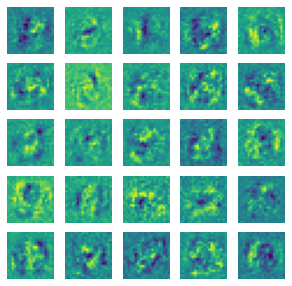

In [167]:
# 16. Визуализируйте скрытый слой обученной сети.

def displayData(thetas):
    fig=plt.figure(figsize=(5, 5))
    for i in range(thetas.shape[0]):
        fig.add_subplot(5, 5, i+1)
        ppl.imshow(thetas[i].reshape(20,20))
        plt.axis('off')
    plt.show()


displayData(theta_hidden_layer[:, 1:])

         Current function value: 1.030511
         Iterations: 100
         Function evaluations: 226
         Gradient evaluations: 226
         Current function value: 0.107363
         Iterations: 100
         Function evaluations: 261
         Gradient evaluations: 261
При большой регуляризации учитываются признаки ближе к центру картинки, при малых зона учитываемых признаков расширяется


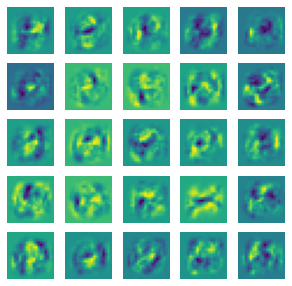

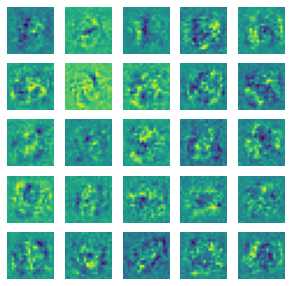

In [168]:
# 17. Подберите параметр регуляризации. Как меняются изображения на скрытом слое в зависимости от данного параметра?

theta_hidden_layer_for_display, _ = train_model(theta1_random, theta2_random, 10, y_one_hot, X)
displayData(theta_hidden_layer_for_display[:, 1:])
theta_hidden_layer_for_display, _ = train_model(theta1_random, theta2_random, 0.1, y_one_hot, X)
displayData(theta_hidden_layer_for_display[:, 1:])

print("При большой регуляризации учитываются признаки ближе к центру картинки, при малых зона учитываемых признаков расширяется")